# mti_extract_write_plot

## Imports

In [1]:
import sys
from pathlib import Path
import re
from datetime import datetime
import numpy as np
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.cm import get_cmap
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
import quantities
from molmass import Formula

## User inputs for plots

In [2]:
D_PLOT = dict(dpi = 600,
              figsize = (12,4),
              fontsize_labels=20,
              fontsize_ticks=14,
              t_std_label="$t\;[\mathrm{h}]$",
              x_std_label="$x$",
              cap_std_label="$Q\;[\mathrm{mAh/g}]$",
              cycle_std_label="$\mathrm{cycle}$",
              ce_std_label="$CE$",
              )

## Other inputs (NB: Please do not edit!)

In [3]:
D_EWE_LABEL = dict(Li=r"$E_{\mathrm{we}}\;\mathrm{vs.\;Li/Li^{+}\;[V]}$",
                   Na=r"$E_{\mathrm{we}}\;\mathrm{vs.\;Na/Na^{+}\;[V]}$",
                   Mg=r"$E_{\mathrm{we}}\;\mathrm{vs.\;Mg/Mg^{2+}\;[V]}$",
                   NMC=r"$E_{\mathrm{we}}\;\mathrm{vs.\;NMC\;[V]}$",
                   LTO=r"$E_{\mathrm{we}}\;\mathrm{vs.\;Li_{4}Ti_{5}O_{12}\;[V]}$",
                   Other=r"$V\;[\mathrm{V}]$",
                   )

D_WORKING_ION = dict(Li=1, Na=1, Mg=2)

D_RGB = dict(red=(255, 0, 0),
             green=(0, 255, 0),
             blue=(0, 0, 255),
             indigo=(75, 0, 130),
             magenta=(255, 0, 255),
             violet=(138, 43, 226),
             purple=(128, 0, 128),
             maroon=(128, 0, 0),
             teal=(0, 128, 128),
             navy=(0, 0, 128),
             cyan=(0, 255, 255),
             )

CMAPS = sorted([e for e in plt.colormaps()], key=str.lower)

D_INDICES = dict(voltage_index = 2,
                 current_index = 3,
                 capacity_index = 5,
                 date_index = -2,
                 time_index = -1,
                 )

## Function definitions

In [4]:
def mti_extract(file, d_indices):
    with file.open(mode="r") as f:
        lines = f.readlines()
    header = lines[0:3]
    lines = lines[3::]
    modes = ["Rest", "CC_Chg", "CC_DChg"]
    start = None
    for i, line in enumerate(lines):
        line = line.split()
        for e in modes:
            if e in line:
                start = i + 1
                break
        if not isinstance(start, type(None)):
            break
    cols = len(lines[start].split())
    cols_cycles = len(lines[start-2].split())
    time_cycle_start = []
    for i in range(len(lines)):
        line_split = lines[i].split()
        if len(line_split) == cols_cycles:
            line_split_data = lines[i+2].split()
            date_split = line_split_data[d_indices["date_index"]].split("-")
            time_split = line_split_data[d_indices["time_index"]].split(":")
            time_cycle_start.append(datetime(int(date_split[0]),
                                             int(date_split[1]),
                                             int(date_split[2]),
                                             int(time_split[0]),
                                             int(time_split[1]),
                                             int(time_split[2])
                                             ).timestamp()
                                    )
    time_cycle_start = np.array(time_cycle_start)
    time_cycle_start = time_cycle_start - time_cycle_start[0]
    voltage, current, capacity, date, time, date_time = [], [], [], [], [], []
    for i in range(start, len(lines)):
        line = lines[i].split()
        if len(line) == cols:
            voltage.append(float(line[d_indices["voltage_index"]]))
            current.append(float(line[d_indices["current_index"]]))
            capacity.append(float(line[d_indices["capacity_index"]]))
            date.append(line[d_indices["date_index"]])
            time.append(line[d_indices["time_index"]])
    for i in range(len(date)):
        date_split = date[i].split("-")
        time_split = time[i].split(":")
        date_time.append(datetime(int(date_split[0]),
                                  int(date_split[1]),
                                  int(date_split[2]),
                                  int(time_split[0]),
                                  int(time_split[1]),
                                  int(time_split[2])
                                  ).timestamp()
                        )
    voltage, current = np.array(voltage), np.array(current) * 10**-3
    capacity = np.array(capacity)
    date_time = np.array(date_time)
    time = date_time - date_time[0]
    d = dict(time=time,
             voltage=voltage,
             current=current,
             capacity=capacity,
             time_cycle_start=time_cycle_start,
             )

    return d


def molar_mass_calc(formula):
    elements = re.sub( r"([A-Z])", r" \1", formula).split()
    molar_mass = 0
    for e in elements:
        s = re.split('(\d.*)', e)
        if len(s) == 1:
            s.append(1)
        if s[-1] == "":
            s = s[0:-1]
        f = Formula(s[0])
        m = float(s[1]) * f.mass
        molar_mass += m

    return molar_mass


def make_x_label(formula, working_ion):
    elements = re.sub( r"([A-Z])", r" \1", formula).split()
    xlabel = "$x\;\mathrm{in\;"
    for i,e in enumerate(elements):
        s = re.split('(\d.*)', e)
        if i == 0 and s[0] != working_ion:
            xlabel += working_ion + "}_{x}\mathrm{" + s[0]
        elif i == 0 and s[0] == working_ion:
            xlabel += str(s[0]) + "}_{x}\mathrm{"
        if i > 0:
            xlabel += str(s[0])
        if len(s) != 1:
            xlabel += "_{" + str(s[1]) + "}"
    xlabel += "}$"

    return xlabel


def x_calc(d, mass, molar_mass, x_start, working_ion_valence):
    time, current = d["time"], d["current"]
    n = mass / molar_mass
    f = physical_constants["Faraday constant"][0]
    x = [x_start]
    for i in range(1, len(time)):
        delta_q =  current[i] * (time[i] - time[i-1]) / working_ion_valence
        delta_x = delta_q / (n * f)
        x.append(x[i-1] + delta_x)
    change_indices = [i for i in range(1, len(current))
                      if current[i] != 0
                      and current[i] * current[i-1] <= 0]
    x, change_indices = np.array(x), np.array(change_indices)

    return x, change_indices


def extract_cycles(d):
    time_cycle_start = d["time_cycle_start"]
    time, voltage, current, x = d["time"], d["voltage"], d["current"], d["x"]
    capacity = d["capacity"]
    cycle_start_indices = []
    for i in range(len(time_cycle_start)):
        for j in range(len(time)):
            if time_cycle_start[i] == time[j]:
                if len(cycle_start_indices) > 0:
                    if time[j] - time[cycle_start_indices[-1]] > 0:
                        cycle_start_indices.append(j)
                else:
                    cycle_start_indices.append(j)
    d_cycles = {}
    for i in range(len(cycle_start_indices)-1):
        d_cycles[i] = dict(time = time[cycle_start_indices[i]:
                                       cycle_start_indices[i+1]
                                       ],
                           voltage = voltage[cycle_start_indices[i]:
                                             cycle_start_indices[i+1]
                                             ],
                           current = current[cycle_start_indices[i]:
                                             cycle_start_indices[i+1]
                                             ],
                           capacity = capacity[cycle_start_indices[i]:
                                               cycle_start_indices[i+1]
                                               ],
                           x = x[cycle_start_indices[i]:
                                 cycle_start_indices[i+1]
                                 ],
                           )
    d_cycles[i+1] = dict(time = time[cycle_start_indices[i+1]::],
                         voltage = voltage[cycle_start_indices[i+1]:],
                         current = current[cycle_start_indices[i+1]:],
                         x = x[cycle_start_indices[i+1]:],
                         capacity = capacity[cycle_start_indices[i+1]:],
                         )

    return d_cycles


def extract_half_cycles(d):
    time_cycle_start = d["time_cycle_start"]
    time, voltage, current, x = d["time"], d["voltage"], d["current"], d["x"]
    capacity = d["capacity"]
    current_end_indices = []
    for i in range(1, len(current)):
        if current[i-1] != 0 and current[i] == 0:
            current_end_indices.append(i)
    d_half_cycles = {"0": dict(time=time[0:current_end_indices[0]],
                               voltage=voltage[0:current_end_indices[0]],
                               current=current[0:current_end_indices[0]],
                               capacity=capacity[0:current_end_indices[0]],
                               x=x[0:current_end_indices[0]],
                               )
                    }
    for i in range(len(current_end_indices)-1):
        d_half_cycles[i+1] = dict(time=time[current_end_indices[i]:
                                            current_end_indices[i+1]
                                            ],
                                  voltage=voltage[current_end_indices[i]:
                                                  current_end_indices[i+1]
                                                  ],
                                  current=current[current_end_indices[i]:
                                                  current_end_indices[i+1]
                                                  ],
                                  capacity=capacity[current_end_indices[i]:
                                                    current_end_indices[i+1]
                                                    ],
                                  x=x[current_end_indices[i]:
                                      current_end_indices[i+1]
                                      ],
                                  )
    d_half_cycles[i+2] = dict(time=time[current_end_indices[i+1]:],
                              voltage=voltage[current_end_indices[i+1]:],
                              current=current[current_end_indices[i+1]:],
                              capacity=capacity[current_end_indices[i+1]:],
                              x=x[current_end_indices[i+1]:],
                              )

    return d_half_cycles


def write(d, output_path):
    keys = list(d.keys())
    header = f"t [s]\tV [V]\tI [A]\tQ [mAh/g]\tx"
    array = d[keys[0]]
    for i in range(1, len(keys)):
        if not keys[i] in ["change_indices", "time_cycle_start"]:
            array = np.column_stack((array, d[keys[i]]))
    np.savetxt(output_path,
               array,
               header=header,
               fmt="%.6e",
               delimiter="\t",
               encoding="utf8",
               )

    return None


def cycles_write(d, output_path):
    cycles = list(d.keys())
    for cycle in cycles:
        keys = list(d[cycle].keys())
        header = f"t [s]\tV [V]\tI [A]\tx"
        array = d[cycle][keys[0]]
        for i in range(1, len(keys)):
            array = np.column_stack((array, d[cycle][keys[i]]))
        cycle = cycle + 1
        zfill = str(cycle).zfill(2)
        fname = f"{output_path.stem}_cycle-{zfill}{output_path.suffix}"
        output_path_cycle = output_path.parent / fname
        np.savetxt(output_path_cycle,
                   array,
                   header=header,
                   fmt="%.6e",
                   delimiter="\t",
                   encoding="utf8",
                   )

    return None


def capacities_extract(d):
    half_cycles = list(d.keys())
    cap_charge, cap_discharge = [], []
    for e in half_cycles:
        current, capacity = d[e]["current"], d[e]["capacity"]
    #     print(e, f"{current[-1]:.6f}", f"{capacity[-1]:.2f}")
    # sys.exit()
        if current[-1] > 10**-5:
            cap_charge.append(capacity[-1])
        else:
            cap_discharge.append(capacity[-1])
    cap_charge, cap_discharge = np.array(cap_charge), np.array(cap_discharge)
    if len(cap_charge) == len(cap_discharge):
        coulomb_eff = cap_discharge / cap_charge
    elif len(cap_charge) > len(cap_discharge):
        coulomb_eff = cap_discharge / cap_charge[0:len(cap_discharge)]
    elif len(cap_charge) < len(cap_discharge):
        coulomb_eff = cap_discharge[0:len(cap_charge)] / cap_charge
    d_caps = dict(charge=cap_charge,
                  discharge=cap_discharge,
                  coulomb_eff=coulomb_eff,
                  )

    return d_caps


def plot_time_voltage(filename, d_data, d_plot, plot_paths, ax=None, save=True):
    time, voltage = d_data["time"]*60**-2, d_data["voltage"]
    plt.style.use(bg_mpl_style)
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    colors = d_plot["colors"](np.linspace(0, 1, 10))
    out = ax.plot(time, voltage, c=colors[-2])
    ax.set_xlabel(d_plot["t_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    ax.set_xlim(np.amin(time), np.amax(time))
    if save:
        for p in plot_paths:
            print(f"\t\t\t{p.parent.name}")
            output_path = p / f"{filename}_t-ewe.{p.parent.name}"
            plt.savefig(output_path, bbox_inches="tight")
        plt.close()

    return out


def plot_x_voltage(filename, d_data, d_plot, plot_paths):
    x, voltage = d_data["x"], d_data["voltage"]
    plt.style.use(bg_mpl_style)
    colors = d_plot["colors"](np.linspace(0, 1, 3))
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    out = ax.plot(x, voltage, color=colors[1])
    ax.set_xlabel(d_plot["x_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    ax.set_xlim(np.amin(x), np.amax(x))
    for p in plot_paths:
        print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_x-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")
    plt.close()

    return out


def plot_x_voltage_cycles_cbar(filename,
                               d,
                               d_plot,
                               plot_paths,
                               ax=None,
                               save=True,
                               ):
    cycles = list(d.keys())
    colors = d_plot["colors"](np.linspace(0, 1, len(cycles)))
    plt.style.use(bg_mpl_style)
    fig, axs = plt.subplots(dpi=d_plot["dpi"],
                            figsize=d_plot["figsize"],
                            ncols=2,
                            gridspec_kw=dict(width_ratios=[1, 0.01]),
                            )
    xmin, xmax = [], []
    for i in range(len(cycles)):
        x, voltage = d[cycles[i]]["x"], d[cycles[i]]["voltage"]
        axs[0].plot(x, voltage, label=str(i+1), c=colors[i])
        xmin.append(np.amin(x))
        xmax.append(np.amax(x))
    xmin, xmax = np.amin(np.array(xmin)), np.amax(np.array(xmax))
    xrange = xmax - xmin
    axs[0].set_xlabel(d_plot["x_label"],
                      fontsize=d_plot["fontsize_labels"],
                      )
    axs[0].set_ylabel(d_plot["ewe_label"],
                      fontsize=d_plot["fontsize_labels"],
                      )
    axs[0].tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    axs[0].minorticks_on()
    axs[0].set_xlim(xmin - 0.01 * xrange, xmax + 0.01 * xrange)
    sm = plt.cm.ScalarMappable(cmap=d_plot["colors"].reversed(),
                               norm=plt.Normalize(vmin=0, vmax=1),
                               )
    cbar = plt.colorbar(sm,
                        cax=axs[1],
                        ticks=[0, 1],
                        )
    cbar.ax.set_yticklabels(["end", "start"])
    cbar.ax.tick_params(axis="y")
    plt.subplots_adjust(wspace=0.05)
    if save:
        for p in plot_paths:
            print(f"\t\t\t{p.parent.name}")
            output_path = p / f"{filename}_x-ewe.{p.parent.name}"
            plt.savefig(output_path, bbox_inches="tight")
        plt.close()

    return axs


def plot_x_voltage_cycles_legend(filename, d, d_plot, plot_paths):
    cycles = list(d.keys())
    colors = d_plot["colors"](np.linspace(0, 1, len(cycles)))
    plt.style.use(bg_mpl_style)
    fig, ax = plt.subplots(dpi=d_plot["dpi"],
                            figsize=d_plot["figsize"],
                            )
    xmin, xmax = [], []
    for i in range(len(cycles)):
        x, voltage = d[cycles[i]]["x"], d[cycles[i]]["voltage"]
        ax.plot(x, voltage, label=str(i+1), c=colors[i])
        xmin.append(np.amin(x))
        xmax.append(np.amax(x))
    xmin, xmax = np.amin(np.array(xmin)), np.amax(np.array(xmax))
    xrange = xmax - xmin
    ax.set_xlabel(d_plot["x_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    ax.set_xlim(xmin - 0.01 * xrange, xmax + 0.01 * xrange)
    if len(cycles) <= 7:
        ncols = len(cycles)
        offset = 0.15
    else:
        ncols = 8
        if 1 < len(cycles) / ncols <= 2:
            offset = 0.25
        elif 2 < len(cycles) / ncols <= 3:
            offset = 0.375
        elif 3 < len(cycles) / ncols <= 4:
            offset = 0.45
        elif 4 < len(cycles) / ncols <= 5:
            offset = 0.55
        else:
            print(f"\t\t\tToo many cycles to get right offset for legend.\n"
                  f"\t\t\tSetting legend offset to 0.\n\t\t\tPlease "
                  f"consider using a colorbar instead of a legend.\n")
            offset = 0
    handles, labels = ax.get_legend_handles_labels()
    handles_sorted, labels_sorted = [], []
    for i in range(ncols):
        for j in range(len(labels)):
            if (int(labels[j]) + ncols - 1) % ncols == i:
                handles_sorted.append(handles[j])
                labels_sorted.append(labels[j])
    ax.legend(handles=handles_sorted,
              labels=labels_sorted,
              loc="upper center",
              bbox_to_anchor=(0.5, 1 + offset),
              ncols=ncols,
              framealpha=0,
              )
    for p in plot_paths:
        print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_x-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")

    return ax


def plot_capacity_voltage_cbar(filename, d, d_plot, plot_paths):
    half_cycles = list(d.keys())
    if len(half_cycles) % 2 != 0:
        n_cycles = int((len(half_cycles) + 1) / 2)
    else:
        n_cycles = int(len(half_cycles) / 2)
    plt.style.use(bg_mpl_style)
    colors = d_plot["colors"](np.linspace(0, 1, n_cycles))
    fig, axs = plt.subplots(dpi=d_plot["dpi"],
                            figsize=d_plot["figsize"],
                            ncols=2,
                            gridspec_kw=dict(width_ratios=[1, 0.01]),
                            )
    xmax = []
    counter = 0
    for i in range(len(half_cycles)):
        capacity = d[half_cycles[i]]["capacity"]
        voltage = d[half_cycles[i]]["voltage"]
        axs[0].plot(capacity, voltage, label=str(counter), c=colors[counter])
        xmax.append(np.amax(capacity))
        if i % 2 != 0:
            counter += 1
    axs[0].set_xlabel(d_plot["cap_std_label"], fontsize=d_plot["fontsize_labels"])
    axs[0].set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    axs[0].tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    axs[0].minorticks_on()
    xmin, xmax = 0, np.amax(xmax)
    xrange = xmax - xmin
    axs[0].set_xlim(xmin, xmax + (0.01 * xrange))
    sm = plt.cm.ScalarMappable(cmap=d_plot["colors"].reversed(),
                               norm=plt.Normalize(vmin=0, vmax=1),
                               )
    cbar = plt.colorbar(sm,
                        cax=axs[1],
                        ticks=[0, 1],
                        )
    cbar.ax.set_yticklabels(["end", "start"])
    cbar.ax.tick_params(axis="y")
    plt.subplots_adjust(wspace=0.05)
    for p in plot_paths:
        print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_cap-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")

    return axs


def plot_capacity_voltage_legend(filename, d, d_plot, plot_paths):
    half_cycles = list(d.keys())
    plt.style.use(bg_mpl_style)
    colors = d_plot["colors"]
    colors = colors(np.linspace(0, 1, int((len(half_cycles) / 2) + 2)))
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    xmax = []
    counter = 0
    for i in range(len(half_cycles)):
        capacity = d[half_cycles[i]]["capacity"]
        voltage = d[half_cycles[i]]["voltage"]
        ax.plot(capacity, voltage, label=str(counter), c=colors[counter])
        xmax.append(np.amax(capacity))
        if i % 2 != 0:
            counter += 1
    ax.set_xlabel(d_plot["cap_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    xmin, xmax = 0, np.amax(xmax)
    xrange = xmax - xmin
    ax.set_xlim(xmin, xmax + (0.01 * xrange))
    for p in plot_paths:
        print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_cap-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")

    return ax


def plot_cycle_capacity(filename, d, d_plot, plot_paths):
    capacity_charge, capacity_discharge = d["charge"], d["discharge"]
    plt.style.use(bg_mpl_style)
    colors = d_plot["colors"](np.linspace(0, 1, 10))
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    ax.scatter(range(1, len(capacity_charge) + 1),
               capacity_charge,
               color=colors[0],
               label="charge",
               )
    ax.scatter(range(1, len(capacity_discharge) + 1),
               capacity_discharge,
               color=colors[-2],
               label="discharge",
               )
    xmin, xmax = 1, max(len(capacity_charge), len(capacity_discharge))
    xrange = xmax - xmin
    ax.set_xlim(xmin - 0.01 * xrange, xmax + 0.01 * xrange)
    ax.set_xlabel(d_plot["cycle_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["cap_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    ax.legend(loc="upper center",
              bbox_to_anchor=(0.5, 1.15),
              ncols=2,
              framealpha=0,
              )
    for p in plot_paths:
        print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_cycle-cap.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")

    return ax


def plot_cycle_ce(filename, d, d_plot, plot_paths):
    ce = d["coulomb_eff"]
    plt.style.use(bg_mpl_style)
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    colors = d_plot["colors"](np.linspace(0, 1, 10))
    ax.scatter(range(1, len(ce) + 1), ce, color=colors[-2])
    xmin, xmax = 1, max(len(ce), len(ce))
    xrange = xmax - xmin
    ax.set_xlim(xmin - 0.01 * xrange, xmax + 0.01 * xrange)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(d_plot["cycle_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ce_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    for p in plot_paths:
        print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_cycle-ce.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")

    return ax

## Main() function definition

In [5]:
def main():
    data_path, txt_path = Path.cwd() / "data", Path.cwd() / "txt"
    png_path, pdf_path = Path.cwd() / "png", Path.cwd() / "pdf"
    svg_path = Path.cwd() / "svg"
    output_paths = [txt_path, png_path, pdf_path, svg_path]
    if not data_path.exists():
        data_path.mkdir()
        sys.exit(f"{80*'-'}\nA folder called 'data' has been created.\n"
                 f"Please place your .txt files containing MTI data there and "
                 f"rerun the program.\n{80*'-'}"
                 )
    data_files = list(data_path.glob("*.txt"))
    if len(data_files) == 0:
        sys.exit(f"{80*'-'}\nNo .txt files were found in the 'data' folder.\n"
                 f"Please place your .txt files containing MTI data there and "
                 f"rerun the program.\n{80*'-'}"
                 )
    for p in output_paths:
        if not p.exists():
            p.mkdir()
    for f in data_files:
        print(f"{80*'-'}\nExtracting data from:\t{f.name}.")
        for p in output_paths:
            if not (p / f.stem).exists():
                (p / f.stem).mkdir()
        txt_path_sample, png_path_sample = txt_path / f.stem, png_path / f.stem
        pdf_path_sample, svg_path_sample = pdf_path / f.stem, svg_path / f.stem
        d_data = mti_extract(f, D_INDICES)
        mass = float(input(f"\tDone extracting data.\n\n\tPlease "
                           f"provide the mass of the active electrode material "
                           f"(in mg): "
                           )
                     ) * 10**-3
        formula = input(f"\n\tPlease provide the empirical formula, e.g. "
                        f"LiFePO4, of the active\n\telectrode material: "
                        )
        molar_mass = molar_mass_calc(formula)
        print(f"\n\tCalculated molar mass for {formula}: {molar_mass:.6f} "
              f"g/mol")
        x_start = float(input(f"\n\tPlease provide the initial value for x, "
                              f"i.e. initial working ion content\n\tof the "
                              f"electrode, e.g. 1 for LiFePO4: "
                              )
                        )
        print(f"\n\tWorking ions...")
        wi_keys = list(D_WORKING_ION.keys())
        for i,k in enumerate(wi_keys):
            print(f"\t\t{i}\t{k}")
        working_ion = wi_keys[int(input(f"\tPlease provide the index of the "
                                        f"working ion: "))]
        working_ion_valence = D_WORKING_ION[working_ion]
        D_PLOT["x_label"] = make_x_label(formula, working_ion)
        print(f"\n\tAvailable counter electrodes...")
        ce_keys = list(D_EWE_LABEL.keys())
        for i,k in enumerate(ce_keys):
            print(f"\t\t{i}\t{k}")
        D_PLOT["ewe_label"] = D_EWE_LABEL[ce_keys[int(input(f"\tPlease provide "
                                                            f"the index of the "
                                                            f"counter "
                                                            f"electrode: "))]]
        print(f"\n\tColorbar or legend...\n\t\t0\tColorbar\n\t\t1\tLegend")
        cbar_vs_legend = input(f"\tPlease indicate whether a colorbar or a "
                               f"legend is preferred: ")
        if cbar_vs_legend == "0":
            D_PLOT["cbar_legend"] = "cbar"
        else:
            D_PLOT["cbar_legend"] = "legend"
        print(f"\n\tColor types...\n\t\t0\tUser-defined sequential colormap "
              f"\n\t\t1\tMatplotlib colormap")
        cmap_type = input(f"\tPlease provide the index to indicate whether you "
                          f"prefer a sequential\n\tcolormap using a "
                          f"user-provided color or a Matplotlib colormap: ")
        if not cmap_type == "1":
            print(f"\n\tAvailable color schemes...")
            rgb_keys = list(D_RGB.keys())
            for i in range(len(rgb_keys)):
                print(f"\t\t{i}\t{rgb_keys[i]}")
            rgb = input(f"\tPlease provide the index of the desired color "
                        f"scheme: ")
            rgb = D_RGB[rgb_keys[int(rgb)]]
            D_PLOT["cmap_type"] = "rgb"
            D_PLOT["colors"] = LinearSegmentedColormap.from_list("my_gradient", (
                               (0.000, (0, 0, 0)),
                               (1.000, (rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)),
                               ))
        else:
            print(f"\n\tMatplotlib colormaps...")
            for i,e in enumerate(CMAPS):
                print(f"\t\t{i}\t{e}")
            D_PLOT["cmap"] = CMAPS[int(input(f"\tPlease provide the index of "
                                             f"the desired colormap: "))]
            D_PLOT["colors"] = get_cmap(D_PLOT["cmap"])
            D_PLOT["cmap_type"] = "mpl"
        print("\n\tCalculating x-values, i.e. state of charge...")
        d_data["x"], d_data["change_indices"] = x_calc(d_data,
                                                       mass,
                                                       molar_mass,
                                                       x_start,
                                                       working_ion_valence,
                                                       )
        d_data["capacity"] = d_data["capacity"] / mass
        d_cycles = extract_cycles(d_data)
        d_half_cycles = extract_half_cycles(d_data)
        d_caps = capacities_extract(d_half_cycles)
        print(f"\tDone calculating x-values.\n\n\tWriting extracted and "
              f"calculated data to '{txt_path_sample.name}' folder."
              )
        write(d_data, txt_path / f.stem / f.name)
        cycles_write(d_cycles, txt_path_sample / f.name)
        print(f"\tDone writing extracted and calculated data to "
              f"'{txt_path.name}' folder.\n\n\tPlotting data..."
              )
        plot_paths_sample = [png_path_sample, pdf_path_sample, svg_path_sample]
        plot_folders = [p.parent.name for p in plot_paths_sample]
        plot_counter = 0
        print(f"\t\ttime vs. voltage...")
        plot_time_voltage(f.stem, d_data, D_PLOT, plot_paths_sample,)
        plot_counter += 1
        print(f"\t\tx vs. voltage...")
        if D_PLOT["cbar_legend"] == "cbar":
            plot_x_voltage_cycles_cbar(f.stem,
                                       d_cycles,
                                       D_PLOT,
                                       plot_paths_sample,
                                       )
            plot_counter += 1
        elif D_PLOT["cbar_legend"] == "legend":
            plot_x_voltage_cycles_legend(f.stem,
                                         d_cycles,
                                         D_PLOT,
                                         plot_paths_sample,
                                         )
            plot_counter += 1
        print(f"\t\tcapacity vs. voltage...")
        if D_PLOT["cbar_legend"] == "cbar":
            plot_capacity_voltage_cbar(f.stem,
                                       d_half_cycles,
                                       D_PLOT,
                                       plot_paths_sample,
                                       )
            plot_counter += 1
        elif D_PLOT["cbar_legend"] == "legend":
            plot_capacity_voltage_legend(f.stem,
                                         d_half_cycles,
                                         D_PLOT,
                                         plot_paths_sample,
                                         )
            plot_counter += 1
        print(f"\t\tcycle number vs. capacity...")
        ax_cycles_cap = plot_cycle_capacity(f.stem,
                                            d_caps,
                                            D_PLOT,
                                            plot_paths_sample,
                                            )
        plot_counter += 1
        print(f"\t\tcycle number vs. couloumbic efficiency...")
        plot_cycle_ce(f.stem, d_caps, D_PLOT, plot_paths_sample)
        plot_counter += 1
        # print(f"\t\tStack plot...")
        # plot_stack(f.stem,
        #            d_data,
        #            d_cycles,
        #            d_half_cycles,
        #            D_PLOT,
        #            plot_paths_sample,
        #            plot_counter,
        #            )
        print(f"\tDone plotting data.\n\tPlease see the {plot_folders} "
              f"folders.")
    print(f"{80*'-'}\nDone working with files.")

    return None

## Running the program

--------------------------------------------------------------------------------
Extracting data from:	NMC811-LTO_IB1.txt.
	Done extracting data.

	Please provide the mass of the active electrode material (in mg): 14.875

	Please provide the empirical formula, e.g. LiFePO4, of the active
	electrode material: LiNi0.8Mn0.1Co0.1O2

	Calculated molar mass for LiNi0.8Mn0.1Co0.1O2: 97.280654 g/mol

	Please provide the initial value for x, i.e. initial working ion content
	of the electrode, e.g. 1 for LiFePO4: 1

	Working ions...
		0	Li
		1	Na
		2	Mg
	Please provide the index of the working ion: 0

	Available counter electrodes...
		0	Li
		1	Na
		2	Mg
		3	NMC
		4	LTO
		5	Other
	Please provide the index of the counter electrode: 4

	Colorbar or legend...
		0	Colorbar
		1	Legend
	Please indicate whether a colorbar or a legend is preferred: 0

	Color types...
		0	User-defined sequential colormap 
		1	Matplotlib colormap
	Please provide the index to indicate whether you prefer a sequential
	color

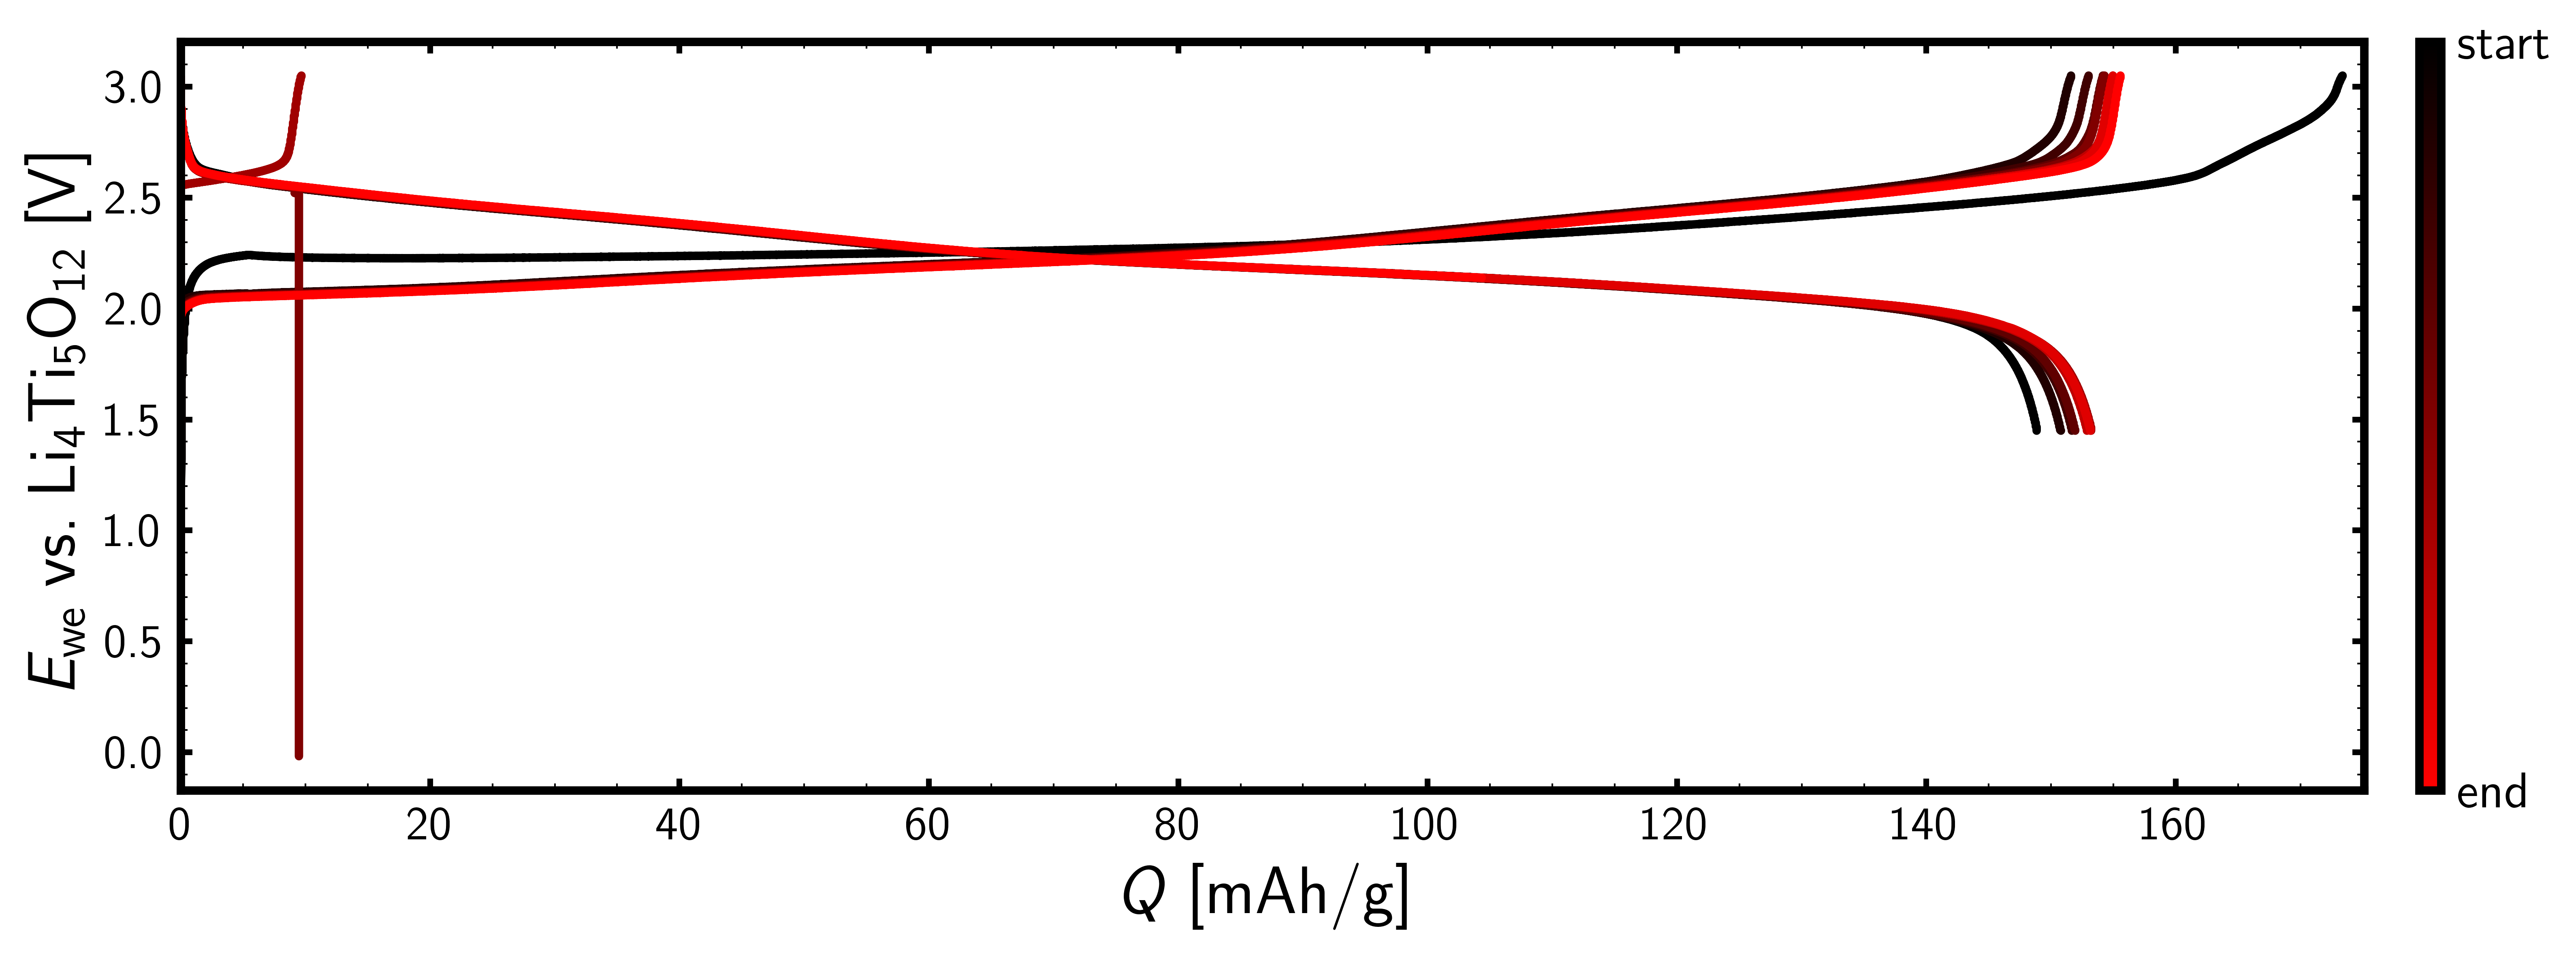

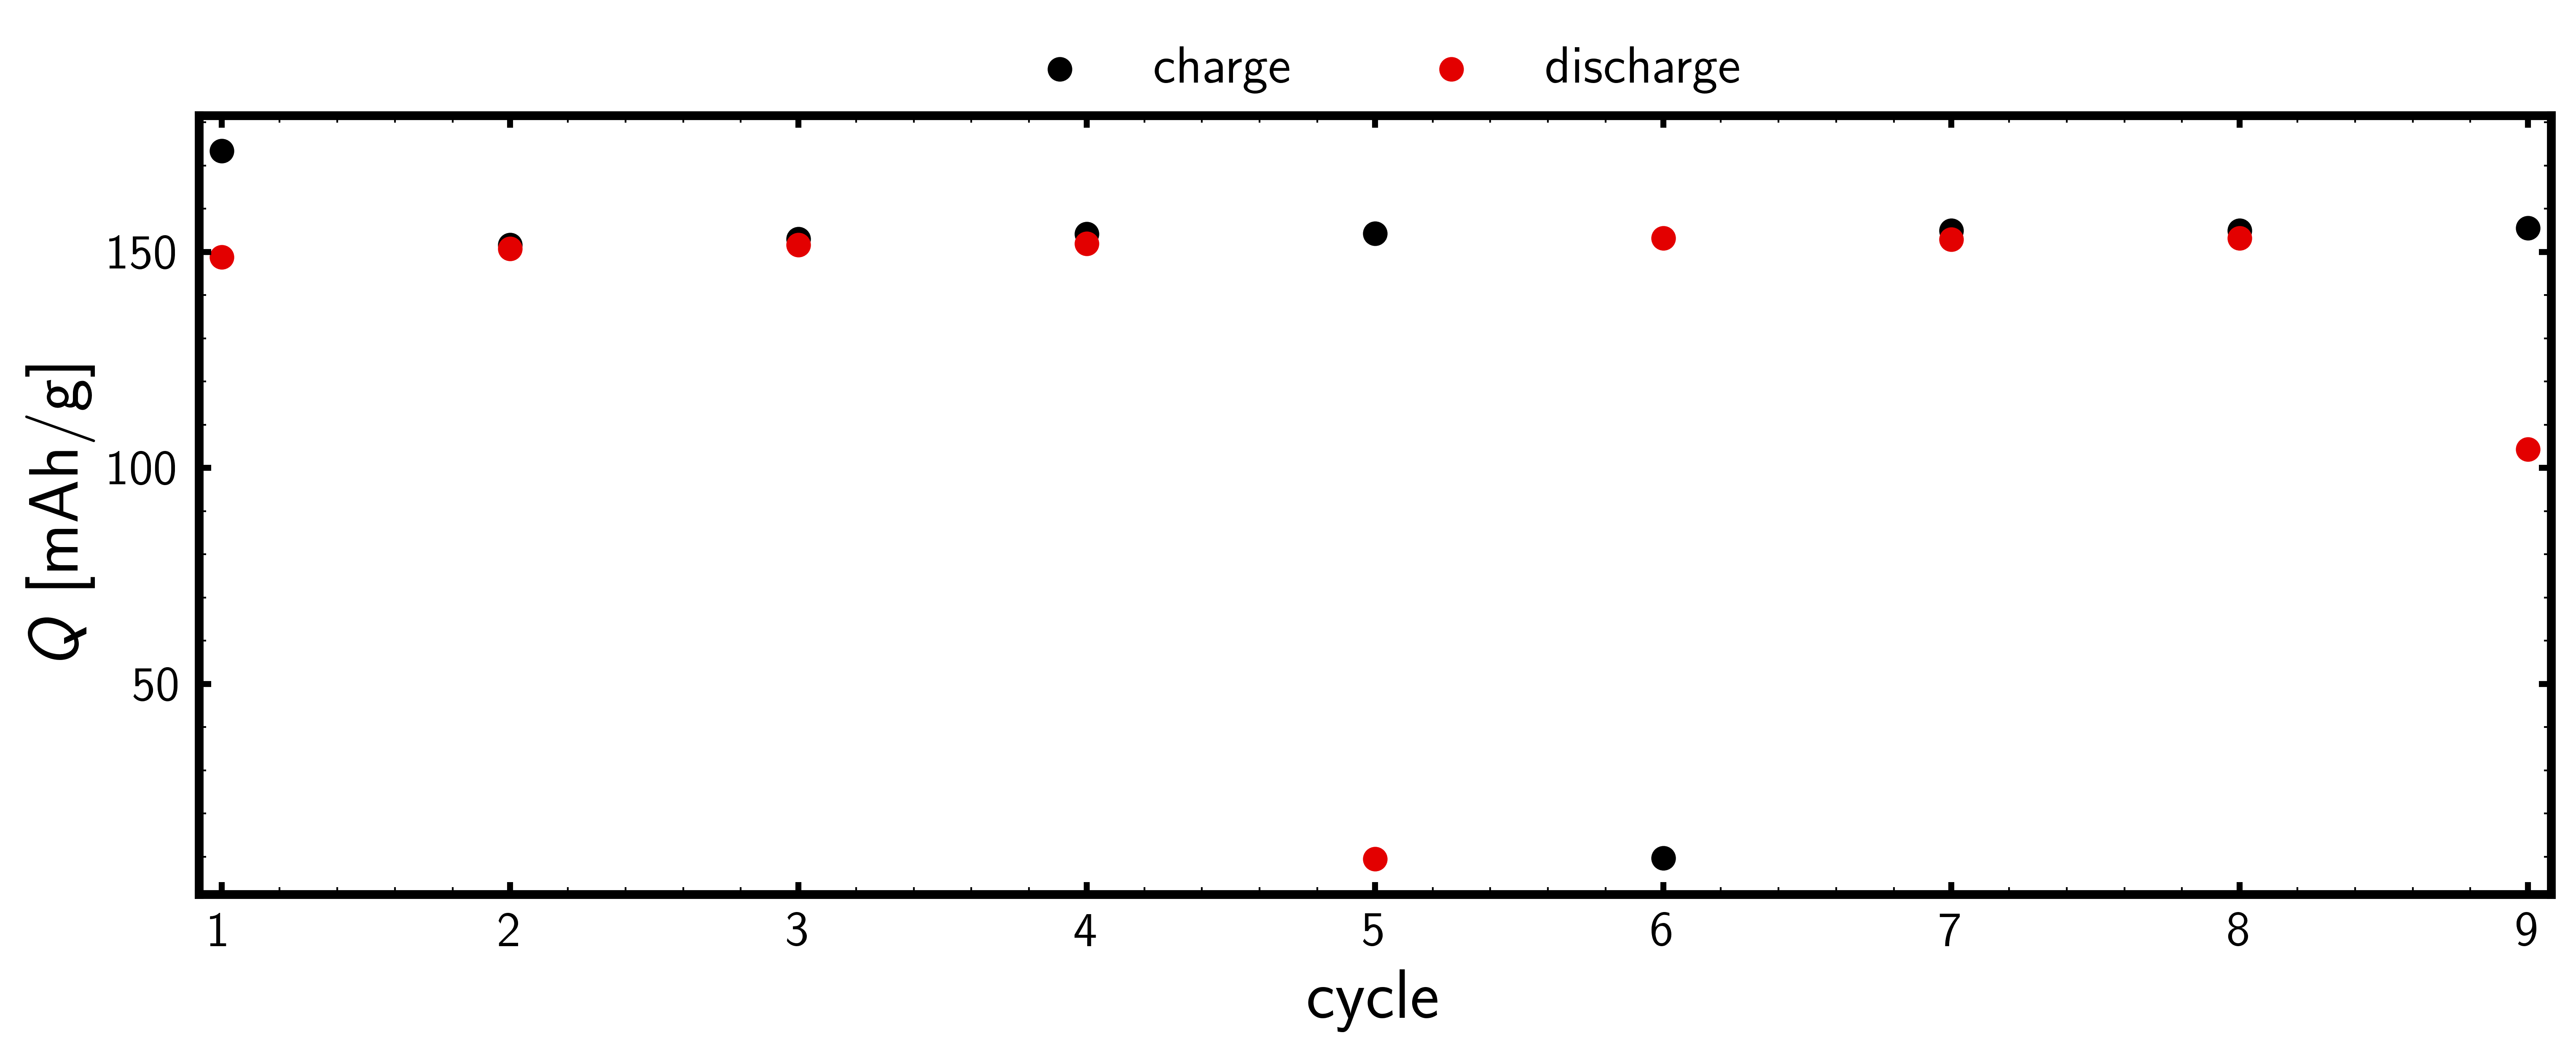

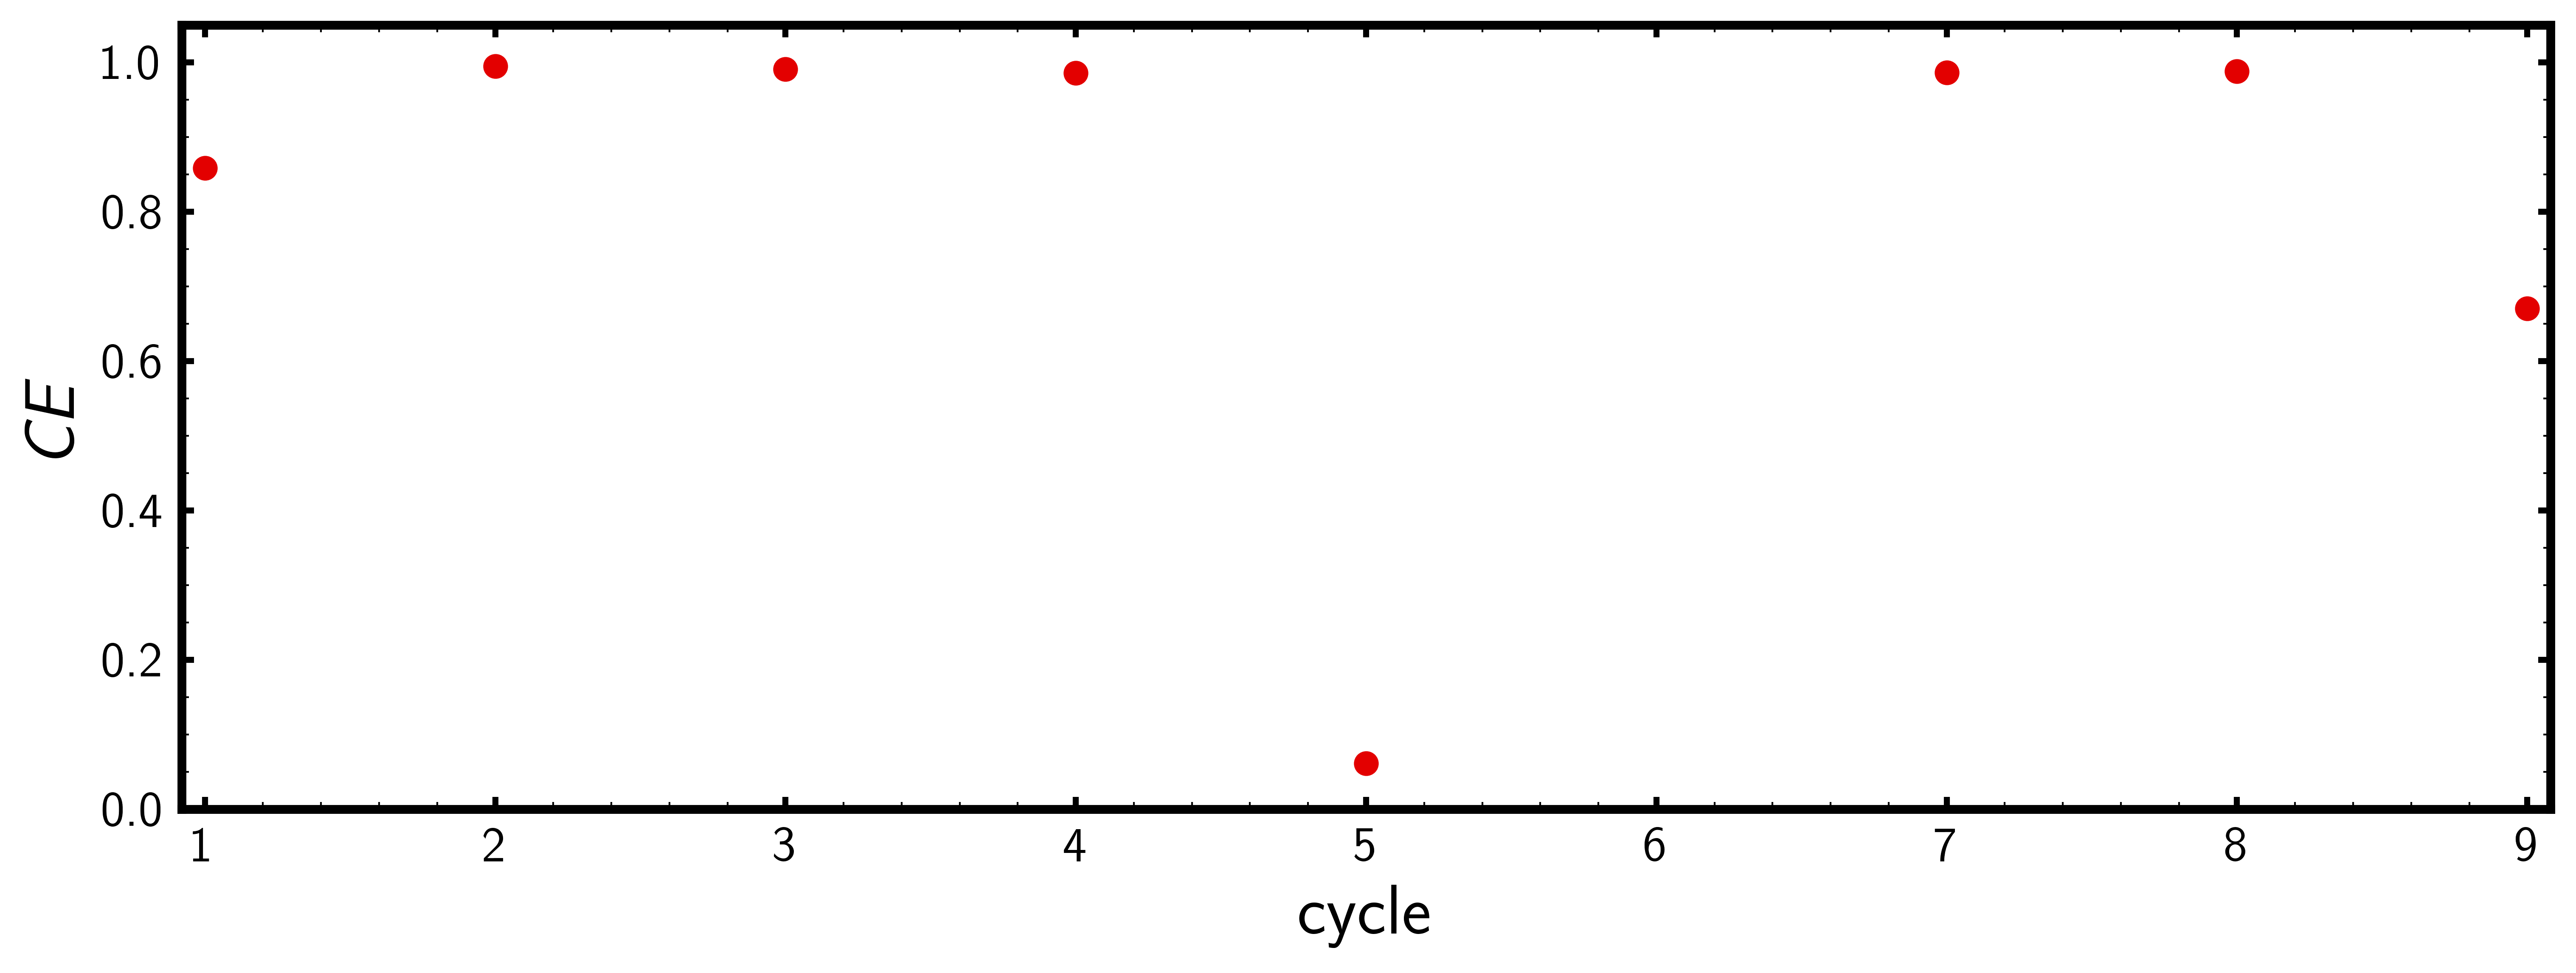

In [6]:
main()